# Marginal Price Curve Estimation for Dispatchable Power in Great Britain

[![Binder](https://notebooks.gesis.org/binder/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/AyrtonB/Merit-Order-Effect/main?filepath=nbs%2Fug-04-electricity-prices.ipynb)

In this example we'll estimate the marginal price curve over the last two months for dispatchable power in Great Britain using data from Electric Insights.

<br>

### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from moepy import retrieval, eda, lowess

<br>

### Data Loading

We'll start by loading in the necessary data from Electric Insights

In [2]:
%%time

current_dt = pd.Timestamp.now()
start_date = (current_dt-pd.Timedelta(weeks=8)).strftime('%Y-%m-%d %H:%M')
end_date = current_dt.strftime('%Y-%m-%d %H:%M')

renaming_dict = {
    'pumpedStorage' : 'pumped_storage',
    'northernIreland' : 'northern_ireland',
    'windOnshore': 'wind_onshore',
    'windOffshore': 'wind_offshore',
    'prices_ahead' : 'day_ahead_price',
    'prices' : 'imbalance_price',
    'temperatures' : 'temperature',
    'totalInGperkWh' : 'gCO2_per_kWh',
    'totalInTperh' : 'TCO2_per_h'
}

df = retrieval.retrieve_streams_df(start_date, end_date, renaming_dict=renaming_dict)

df.head()

Wall time: 7.75 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2021-02-01 00:00:00+00:00,51.99,1,68.95,68.95,2.9,4797.759,175.799988,5.564,1.945,0.465,...,27.291009,0.0,3.028282,3.514363,0.902,0.0,1.806,0.0,0.018,-0.050
2021-02-01 00:30:00+00:00,54.19,2,69.00,69.00,2.9,5149.705,186.030814,5.559,1.963,0.563,...,27.682000,0.0,2.903885,3.447460,0.902,0.0,1.806,0.0,0.016,0.016
2021-02-01 01:00:00+00:00,55.07,3,75.00,75.00,2.9,5177.972,189.308716,5.565,2.077,0.680,...,27.352000,0.0,2.764132,3.361527,0.952,0.0,1.906,0.0,0.018,0.018
2021-02-01 01:30:00+00:00,56.30,4,72.00,72.00,2.9,5131.084,190.891574,5.563,2.122,0.716,...,26.879573,0.0,2.624037,3.193860,0.952,0.0,1.906,0.0,0.016,0.016
2021-02-01 02:00:00+00:00,56.71,5,75.00,75.00,2.9,5105.370,193.368381,5.561,2.134,0.718,...,26.402300,0.0,2.417506,2.934586,0.926,0.0,1.906,0.0,0.018,0.018


<br>

We'll quickly visualise the relationship between price and dispatchable load for each half-hour period

Text(0, 0.5, 'Price (£/MWh)')

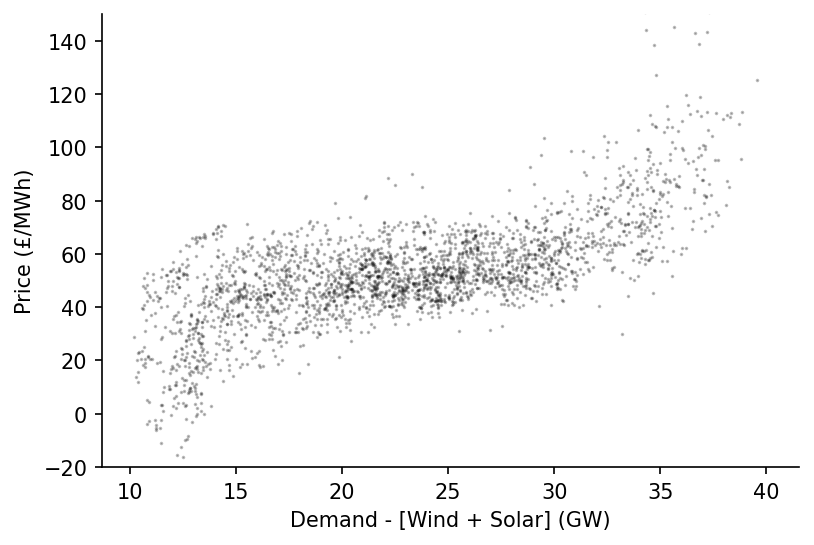

In [3]:
df_model = df[['day_ahead_price', 'demand', 'solar', 'wind']].dropna().astype(float)

s_price = df_model['day_ahead_price']
s_dispatchable = df_model['demand'] - df_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable, s_price, s=0.5, alpha=0.25, color='k')

ax.set_ylim(-20, 150)
eda.hide_spines(ax)
ax.set_xlabel('Demand - [Wind + Solar] (GW)')
ax.set_ylabel('Price (£/MWh)')

<br>

### Marginal Price Curve Estimation

We're now ready to fit our LOWESS model

<AxesSubplot:>

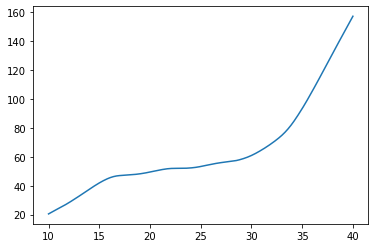

In [4]:
x_pred = np.linspace(10, 40, 301)

y_pred = lowess.lowess_fit_and_predict(s_dispatchable.values, 
                                       s_price.values, 
                                       frac=0.25, 
                                       num_fits=25, 
                                       x_pred=x_pred)

pd.Series(y_pred, index=x_pred).plot()

<br>

We'll then visualise the estimated fit alongside the historical observations

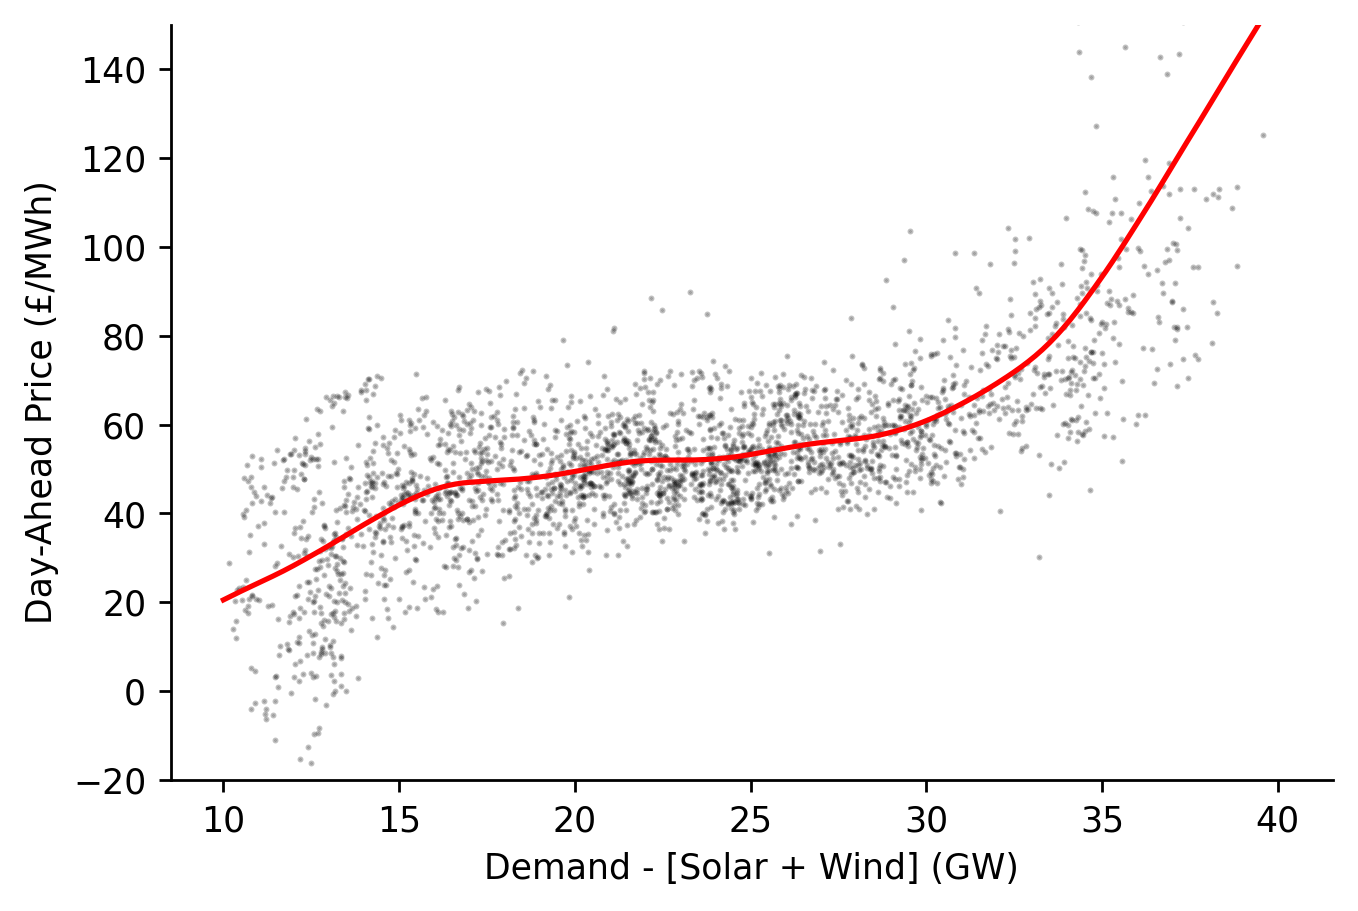

In [5]:
fig, ax = plt.subplots(dpi=250)

ax.plot(x_pred, y_pred, linewidth=1.5, color='r')
ax.scatter(s_dispatchable, s_price, color='k', s=0.5, alpha=0.25)

ax.set_ylim(-20, 150)
eda.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (GW)')
ax.set_ylabel('Day-Ahead Price (£/MWh)')
fig.savefig('../img/latest_gb_mcc.png', dpi=250)